### Preparing data

In [1]:
# Already exists
# !wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv

In [2]:
import numpy as np
import pandas as pd
df = pd.read_csv('course_lead_scoring.csv')
df

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1
...,...,...,...,...,...,...,...,...,...
1457,referral,manufacturing,1,NaN,self_employed,north_america,4,0.53,1
1458,referral,technology,3,65259.0,student,europe,2,0.24,1
1459,paid_ads,technology,1,45688.0,student,north_america,3,0.02,1
1460,referral,NaN,5,71016.0,self_employed,north_america,0,0.25,1


In [3]:
# Checking missing values
df.isnull().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [4]:
# Checking data types
df.dtypes

lead_source                  object
industry                     object
number_of_courses_viewed      int64
annual_income               float64
employment_status            object
location                     object
interaction_count             int64
lead_score                  float64
converted                     int64
dtype: object

In [5]:
# Checking the number of unique values to determine whether some variables are better be put as numerical or categorical
df.nunique()

lead_source                    5
industry                       7
number_of_courses_viewed      10
annual_income               1267
employment_status              4
location                       7
interaction_count             12
lead_score                   101
converted                      2
dtype: int64

In [6]:
# Defining numerical and categorical variables
numerical = ['number_of_courses_viewed', 'annual_income', 'interaction_count', 'lead_score']
categorical = ['lead_source', 'industry', 'employment_status', 'location']

In [7]:
# Replacing numerical missing values with 0.0
df[numerical] = df[numerical].fillna(0.0)
df[numerical]

,number_of_courses_viewed,annual_income,interaction_count,lead_score
0,1,79450.0,4,0.94
1,1,46992.0,1,0.80
2,5,78796.0,3,0.69
3,2,83843.0,1,0.87
4,3,85012.0,3,0.62
...,...,...,...,...
1457,1,0.0,4,0.53
1458,3,65259.0,2,0.24
1459,1,45688.0,3,0.02
1460,5,71016.0,0,0.25


In [8]:
df[numerical].isna().sum()

number_of_courses_viewed    0
annual_income               0
interaction_count           0
lead_score                  0
dtype: int64

In [9]:
# Replacing categorical missing values with 'NA'
df[categorical] = df[categorical].fillna('NA')
df[categorical]

,lead_source,industry,employment_status,location
0,paid_ads,NA,unemployed,south_america
1,social_media,retail,employed,south_america
2,events,healthcare,unemployed,australia
3,paid_ads,retail,NA,australia
4,referral,education,self_employed,europe
...,...,...,...,...
1457,referral,manufacturing,self_employed,north_america
1458,referral,technology,student,europe
1459,paid_ads,technology,student,north_america
1460,referral,NA,self_employed,north_america


In [10]:
df[categorical].isnull().sum()

lead_source          0
industry             0
employment_status    0
location             0
dtype: int64

In [11]:
# Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. 
# Use train_test_split function for that with random_state=1
from sklearn.model_selection import train_test_split
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)
len(df_train), len(df_val), len(df_test)

(876, 293, 293)

### Question 1. ROC AUC feature importance

In [19]:
from sklearn.metrics import roc_auc_score

roc_scores = {}

# Getting y_train
y_train = df_train['converted'].values

for var in numerical:
    # Getting y_pred
    y_pred = df_train[var].values

    auc = roc_auc_score(y_train, y_pred)

    if auc < 0.5:
        y_pred = -df_train[var].values
        auc = roc_auc_score(y_train, y_pred)

    # Calculating AUC
    roc_scores[var] = auc
    print(f"{var}: {auc:.4f}")

best_variable = max(roc_scores, key=roc_scores.get)
print(f"\nVariable with highest AUC: {best_variable} (AUC = {roc_scores[best_variable]:.4f})")

number_of_courses_viewed: 0.7636
annual_income: 0.5520
interaction_count: 0.7383
lead_score: 0.6145

Variable with highest AUC: number_of_courses_viewed (AUC = 0.7636)


### Question 2. Training the model

In [20]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# Prepare training data
y_train = df_train['converted'].values
train_dict = df_train[categorical + numerical].to_dict(orient='records')

# Fit DictVectorizer on training data
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dict)

# Train logistic regression model
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

# Prepare validation data
y_val = df_val['converted'].values
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

# Get predictions and calculate AUC
y_pred = model.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)

print(f"AUC on validation dataset: {auc:.3f}")

AUC on validation dataset: 0.817


### Question 3. Precision and Recall

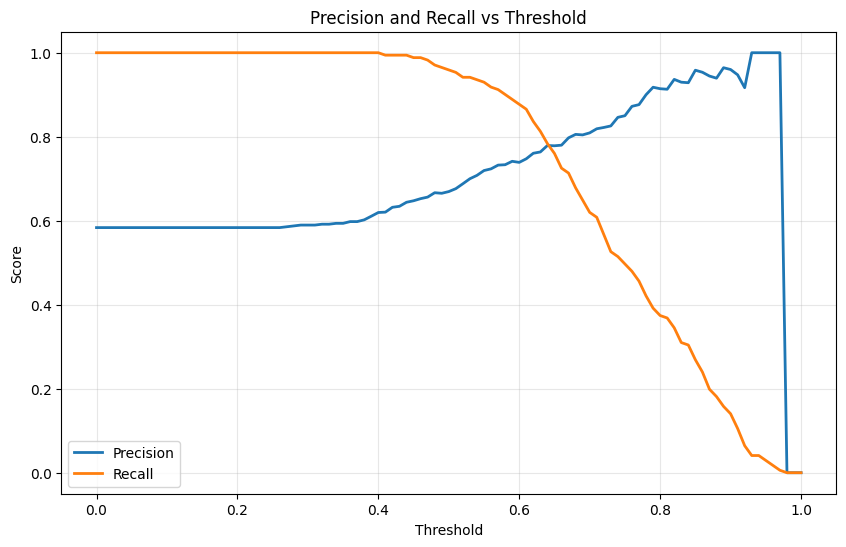

First intersection at threshold: 0.6400
Precision at intersection: 0.779
Recall at intersection: 0.784


In [27]:
from sklearn.metrics import precision_score, recall_score
import matplotlib.pyplot as plt

# Generate thresholds from 0.0 to 1.0 with step 0.01
thresholds = np.arange(0.0, 1.01, 0.01)

# Lists to store precision and recall values
precisions = []
recalls = []

# For each threshold, compute precision and recall
for threshold in thresholds:
    # Convert probabilities to binary predictions based on threshold
    y_pred_binary = (y_pred >= threshold).astype(int)
    
    # Calculate precision and recall
    # Use zero_division=0 to handle cases where there are no positive predictions
    precision = precision_score(y_val, y_pred_binary, zero_division=0)
    recall = recall_score(y_val, y_pred_binary, zero_division=0)
    
    precisions.append(precision)
    recalls.append(recall)

# Plot precision and recall curves
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision', linewidth=2)
plt.plot(thresholds, recalls, label='Recall', linewidth=2)
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs Threshold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Find the intersection point
# Look for where precision and recall switch positions (cross over)
intersection_threshold = None

for i in range(len(thresholds) - 1):
    # Check if precision and recall cross between this threshold and the next
    if (precisions[i] <= recalls[i] and precisions[i+1] > recalls[i+1]) or \
       (precisions[i] >= recalls[i] and precisions[i+1] < recalls[i+1]):
        # Found a crossing point
        intersection_threshold = thresholds[i]
        intersection_idx = i
        break

if intersection_threshold is not None:
    print(f"First intersection at threshold: {intersection_threshold:.4f}")
    print(f"Precision at intersection: {precisions[intersection_idx]:.3f}")
    print(f"Recall at intersection: {recalls[intersection_idx]:.3f}")
else:
    print("No intersection found")

### Question 4. F1 score

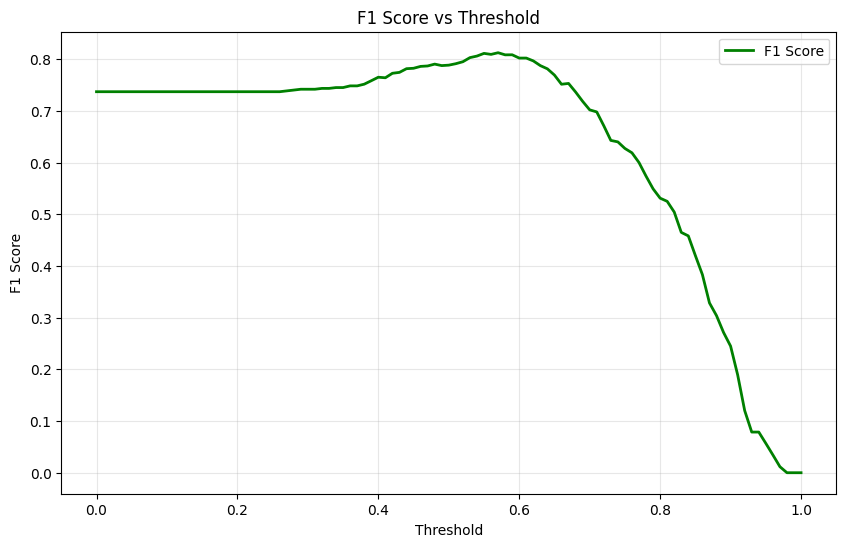

F1 is maximal at threshold: 0.57
Maximum F1 score: 0.812


In [22]:
# Lists to store F1 scores
f1_scores = []

# For each threshold, compute F1 score
for threshold in thresholds:
    # Convert probabilities to binary predictions based on threshold
    y_pred_binary = (y_pred >= threshold).astype(int)
    
    # Calculate precision and recall
    precision = precision_score(y_val, y_pred_binary, zero_division=0)
    recall = recall_score(y_val, y_pred_binary, zero_division=0)
    
    # Calculate F1 score
    if precision + recall == 0:
        f1 = 0
    else:
        f1 = 2 * precision * recall / (precision + recall)
    
    f1_scores.append(f1)

# Plot F1 score
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, label='F1 Score', linewidth=2, color='green')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Threshold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Find the threshold with maximum F1 score
max_f1_idx = np.argmax(f1_scores)
max_f1_threshold = thresholds[max_f1_idx]
max_f1_score = f1_scores[max_f1_idx]

print(f"F1 is maximal at threshold: {max_f1_threshold:.2f}")
print(f"Maximum F1 score: {max_f1_score:.3f}")

### Question 5. 

In [23]:
from sklearn.model_selection import KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import numpy as np

# Initialize KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

# List to store AUC scores for each fold
auc_scores = []

# Iterate over different folds
for fold, (train_idx, val_idx) in enumerate(kfold.split(df_full_train), 1):
    # Split the data into train and validation
    df_train_fold = df_full_train.iloc[train_idx]
    df_val_fold = df_full_train.iloc[val_idx]
    
    # Prepare training data
    y_train_fold = df_train_fold['converted'].values
    train_dict = df_train_fold[categorical + numerical].to_dict(orient='records')
    
    # Fit DictVectorizer and transform training data
    dv = DictVectorizer(sparse=False)
    X_train_fold = dv.fit_transform(train_dict)
    
    # Train the model
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train_fold, y_train_fold)
    
    # Prepare validation data
    y_val_fold = df_val_fold['converted'].values
    val_dict = df_val_fold[categorical + numerical].to_dict(orient='records')
    X_val_fold = dv.transform(val_dict)
    
    # Predict and calculate AUC
    y_pred_fold = model.predict_proba(X_val_fold)[:, 1]
    auc = roc_auc_score(y_val_fold, y_pred_fold)
    
    auc_scores.append(auc)
    print(f"Fold {fold}: AUC = {auc:.3f}")

# Calculate mean and standard deviation
mean_auc = np.mean(auc_scores)
std_auc = np.std(auc_scores)

print(f"\nMean AUC: {mean_auc:.3f}")
print(f"Standard deviation: {std_auc:.3f}")

Fold 1: AUC = 0.806
Fold 2: AUC = 0.871
Fold 3: AUC = 0.775
Fold 4: AUC = 0.802
Fold 5: AUC = 0.856

Mean AUC: 0.822
Standard deviation: 0.036


### Question 6. Hyperparameter Tuning

In [25]:
from sklearn.model_selection import KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import numpy as np

# C values to test
C_values = [0.000001, 0.001, 1]

# Store results for each C
results = {}

# For each C value
for C in C_values:
    print(f"\nTesting C = {C}")
    
    # Initialize KFold
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    
    # List to store AUC scores for each fold
    auc_scores = []
    
    # Iterate over different folds
    for fold, (train_idx, val_idx) in enumerate(kfold.split(df_full_train), 1):
        # Split the data into train and validation
        df_train_fold = df_full_train.iloc[train_idx]
        df_val_fold = df_full_train.iloc[val_idx]
        
        # Prepare training data
        y_train_fold = df_train_fold['converted'].values
        train_dict = df_train_fold[categorical + numerical].to_dict(orient='records')
        
        # Fit DictVectorizer and transform training data
        dv = DictVectorizer(sparse=False)
        X_train_fold = dv.fit_transform(train_dict)
        
        # Train the model with current C
        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train_fold, y_train_fold)
        
        # Prepare validation data
        y_val_fold = df_val_fold['converted'].values
        val_dict = df_val_fold[categorical + numerical].to_dict(orient='records')
        X_val_fold = dv.transform(val_dict)
        
        # Predict and calculate AUC
        y_pred_fold = model.predict_proba(X_val_fold)[:, 1]
        auc = roc_auc_score(y_val_fold, y_pred_fold)
        
        auc_scores.append(auc)
    
    # Calculate mean and standard deviation
    mean_auc = np.round(np.mean(auc_scores), 3)
    std_auc = np.round(np.std(auc_scores), 3)
    
    results[C] = {'mean': mean_auc, 'std': std_auc}
    print(f"C = {C}: Mean AUC = {mean_auc:.3f} ± {std_auc:.3f}")

# Find the best C
best_C = max(results, key=lambda x: results[x]['mean'])
print(f"\nBest C: {best_C}")
print(f"Best Mean AUC: {results[best_C]['mean']:.3f}")
print(f"Std: {results[best_C]['std']:.3f}")


Testing C = 1e-06
C = 1e-06: Mean AUC = 0.560 ± 0.024

Testing C = 0.001
C = 0.001: Mean AUC = 0.867 ± 0.029

Testing C = 1
C = 1: Mean AUC = 0.822 ± 0.036

Best C: 0.001
Best Mean AUC: 0.867
Std: 0.029
